In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay

In [2]:
# Load data
data = pd.read_csv('customerchurn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Check dimension of data
data.shape

(7043, 21)

In [4]:
# Understand column types
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# Understand numerical data
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Note that this is a classification problem due to lack of numerical data.

In [6]:
# Check for missing values
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There are no missing values in the dataset.

In [7]:
# Check for duplicates
data.duplicated().sum()

0

In [8]:
# Drop unneeded ID column
data.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric and handle errors
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)

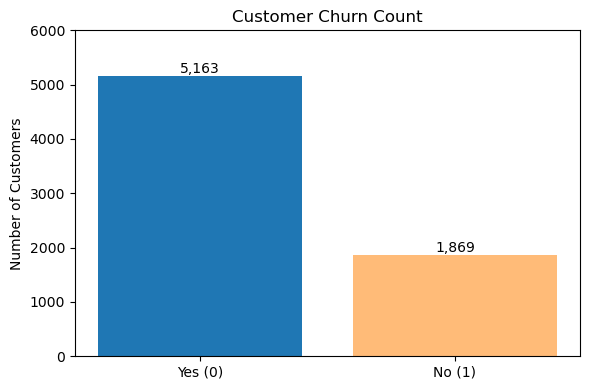

In [9]:
#Check imbalance within the dataset

# Count of each class
class_counts = data['Churn'].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index, class_counts.values, color=['#1f77b4', '#ffbb78'])

# Set labels and ticks
plt.xticks([0, 1], ['Yes (0)', 'No (1)'])
plt.ylabel('Number of Customers')
plt.title('Customer Churn Count')

# Set y-axis increments to 1000
max_count = max(class_counts.values)
plt.yticks(range(0, int(max_count + 1000), 1000))

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height):,}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
# One-hot encode categorical features (including 'Churn')
categorical_cols = data.select_dtypes(include='object').columns.tolist()
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

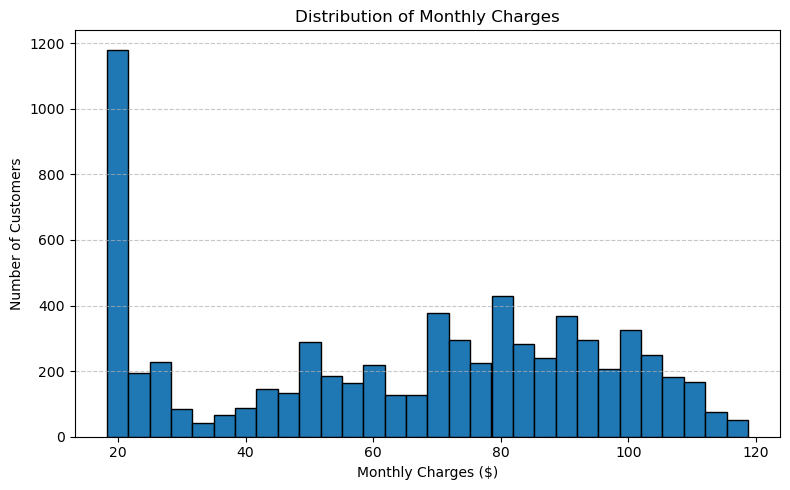

In [11]:
# Distribution chart for Monthly Charges
plt.figure(figsize=(8, 5))
plt.hist(data['MonthlyCharges'], bins=30, color='#1f77b4', edgecolor='black')  # Dark blue
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

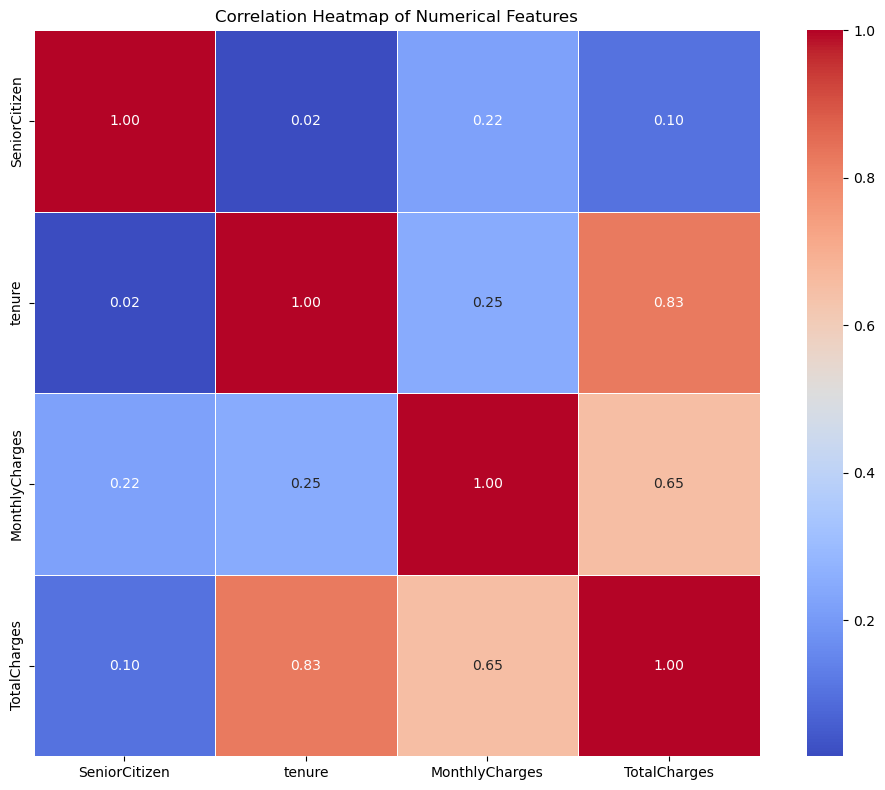

In [12]:
# Compute correlation matrix (only numerical columns)
corr_matrix = data.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

In [13]:
# Split features and target variables

X = data_encoded.drop('Churn_Yes', axis=1)
y = data_encoded['Churn_Yes']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [14]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [15]:
# Define Models
# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_res, y_train_res)

# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)

# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb.fit(X_train_res, y_train_res)

C:\Users\chris\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\chris\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=-1,
              num_parallel_tree=None, ...)

In [16]:
# Evaluate models

# Store results
results = []

models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probability for ROC AUC
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Precision': report['True']['precision'],
        'Recall': report['True']['recall'],
        'F1-Score': report['True']['f1-score'],
        'ROC AUC': roc_auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).round(4)

# Display the table
results_df

,Model,Precision,Recall,F1-Score,ROC AUC
0,Logistic Regression,0.5414,0.6471,0.5895,0.8124
1,Random Forest,0.5164,0.7139,0.5993,0.8319
2,XGBoost,0.5550,0.6471,0.5975,0.8291


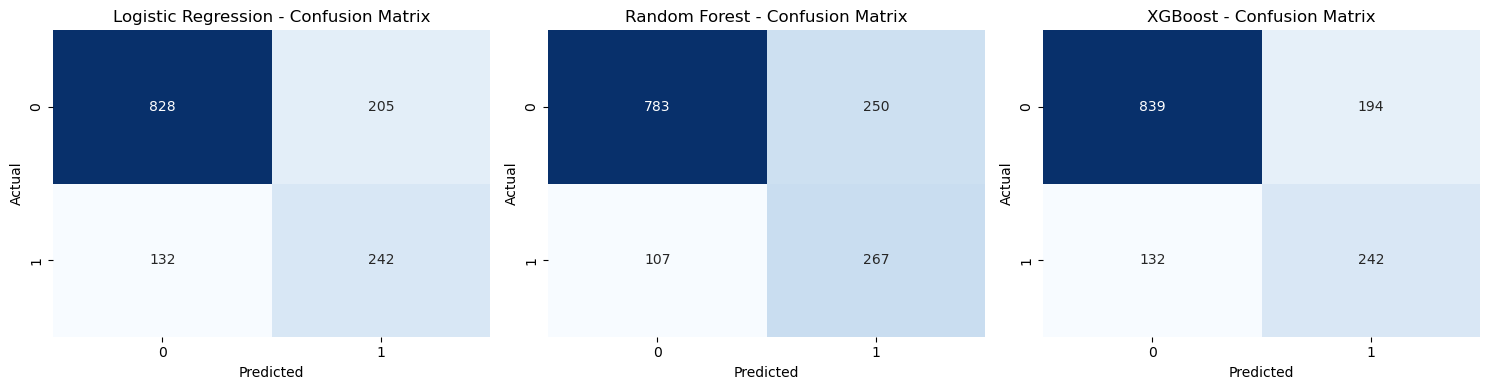

In [17]:
# Confusion matrices for each model
models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

# Plot confusion matrices
plt.figure(figsize=(15, 4))
for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

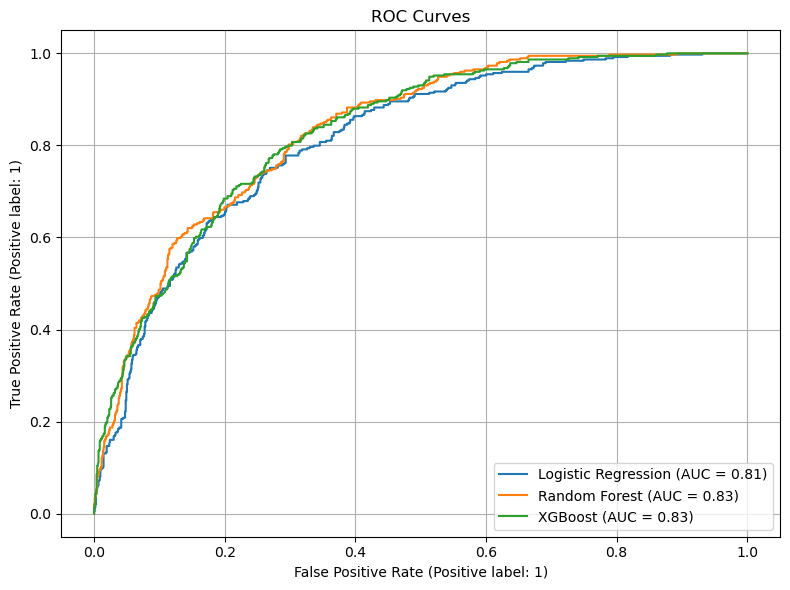

In [18]:
# ROC curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=plt.gca())

plt.title('ROC Curves')
plt.grid(True)
plt.tight_layout()
plt.show()

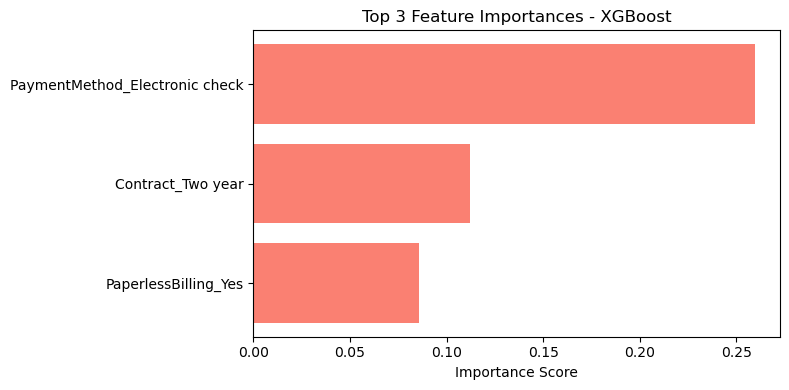

In [19]:
# Calculate and prepare feature importances for XGBoost
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns)
top3 = xgb_importances.sort_values(ascending=False).head(3)

# Convert to DataFrame for plotting
xgb_df = top3.reset_index()
xgb_df.columns = ['Feature', 'Importance']

# Plot
plt.figure(figsize=(8, 4))
plt.barh(xgb_df['Feature'], xgb_df['Importance'], color='salmon')
plt.gca().invert_yaxis()
plt.title('Top 3 Feature Importances - XGBoost')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()